In [11]:
import pandas as pd
from collections import defaultdict, deque


df = pd.read_csv('routes_raw_data - routes_raw_data (2).csv')

# df = df[df['Направление движения'] == 2 ]

df = df[df['Тип транспорта'] == 'Трамвай']

print("=== АНАЛИЗ СВЯЗНОСТИ МАРШРУТОВ ===")
print(f"Всего записей: {len(df)}")
print(f"Уникальных маршрутов: {df['Идентификатор маршрута'].nunique()}")
print(f"Уникальных остановок: {df['ID остановки'].nunique()}\n")

# 1. Построение графа связности
graph = defaultdict(set)
route_stops = defaultdict(set)  # остановки по маршрутам

for _, row in df.iterrows():
    stop_id = row['ID остановки']
    next_stop = row['ID следующей остановки']
    route_id = f"{row['Идентификатор маршрута']}_{row['Числовой номер маршрута']}"

    # Добавляем связь между текущей и следующей остановкой
    if next_stop:
        graph[stop_id].add(next_stop)
        graph[next_stop].add(stop_id)  # для неориентированного графа

    # Добавляем остановку в маршрут
    route_stops[route_id].add(stop_id)
    if next_stop:
        route_stops[route_id].add(next_stop)

# 2. Поиск компонент связности (connected components)
def find_connected_components(graph):
    visited = set()
    components = []

    for node in graph:
        if node not in visited:
            # BFS для поиска компоненты
            component = []
            queue = deque([node])

            while queue:
                current = queue.popleft()
                if current not in visited:
                    visited.add(current)
                    component.append(current)
                    # Добавляем соседей
                    for neighbor in graph.get(current, []):
                        if neighbor not in visited:
                            queue.append(neighbor)

            if component:
                components.append(component)

    return components

# 3. Анализ пересадок между маршрутами
def analyze_transfers(route_stops):
    """Анализирует общие остановки между маршрутами"""
    routes = list(route_stops.keys())
    transfers = defaultdict(list)

    for i in range(len(routes)):
        for j in range(i + 1, len(routes)):
            route1 = routes[i]
            route2 = routes[j]
            common_stops = route_stops[route1] & route_stops[route2]

            if common_stops:
                transfers[(route1, route2)] = list(common_stops)

    return transfers

# 4. Анализ степени вершин (важности остановок)
def analyze_stop_importance(graph):
    """Анализирует важность остановок по количеству связей"""
    importance = {}
    for stop, neighbors in graph.items():
        importance[stop] = {
            'degree': len(neighbors),
            'neighbors': list(neighbors)
        }
    return importance

# Выполняем анализ
components = find_connected_components(graph)
transfers = analyze_transfers(route_stops)
importance = analyze_stop_importance(graph)

# # Получить массив уникальных значений
# unique_types = df['Числовой номер маршрута'].unique()
# print("Уникальные значения:")
# print(unique_types)
# print(f"Всего уникальных типов: {len(unique_types)}")


print("=== КОМПОНЕНТЫ СВЯЗНОСТИ ===")
print(f"Всего компонент связности: {len(components)}")
for i, component in enumerate(components, 1):
    print(f"Компонента {i}: {len(component)} остановок")
    if len(component) <= 10:  # Показываем небольшие компоненты полностью
        print(f"  Остановки: {component}")


print("\n=== ВАЖНЫЕ ОСТАНОВКИ (ХАБЫ) ===")
# Сортируем остановки по степени важности
sorted_importance = sorted(importance.items(), key=lambda x: x[1]['degree'], reverse=True)

print("Топ-5 самых связанных остановок:")
for i, (stop_id, data) in enumerate(sorted_importance[:5], 1):
    stop_name = df[df['ID остановки'] == stop_id]['Название остановки']
    name = stop_name.values[0] if len(stop_name) > 0 else "Название не найдено"
    print(f"{i}. ID {stop_id} ({name}): {data['degree']} связей")

print("\n=== СТАТИСТИКА ГРАФА ===")
print(f"Всего узлов (остановок) в графе: {len(graph)}")
print(f"Всего рёбер (связей) в графе: {sum(len(neighbors) for neighbors in graph.values()) // 2}")



=== АНАЛИЗ СВЯЗНОСТИ МАРШРУТОВ ===
Всего записей: 1907
Уникальных маршрутов: 42
Уникальных остановок: 886

=== КОМПОНЕНТЫ СВЯЗНОСТИ ===
Всего компонент связности: 1
Компонента 1: 886 остановок

=== ВАЖНЫЕ ОСТАНОВКИ (ХАБЫ) ===
Топ-5 самых связанных остановок:
1. ID 16008 (Пр. Энергетиков, по требованию): 5 связей
2. ID 24308 (Конечная станция "Пр. Солидарности" (посадки и высадки нет)): 4 связей
3. ID 32392 (Гранитная ул): 4 связей
4. ID 15959 (Ул. Руставели, 29): 4 связей
5. ID 16651 (Ул. Руставели, 29): 4 связей

=== СТАТИСТИКА ГРАФА ===
Всего узлов (остановок) в графе: 886
Всего рёбер (связей) в графе: 989


In [12]:
df.head()

,6,Идентификатор маршрута,Числовой номер маршрута,Наименование маршрута,Тип транспорта,Направление движения,ID остановки,ID следующей остановки,"Расстояние до следующей остановки, км",Название остановки,Координаты остановки
0,1,1125,А,Река Оккервиль - Ул. Коллонтай,Трамвай,1,16396,16367,0.80,"Конечная станция ""Река Оккервиль""","59.908880895247805,30.4946709"
1,2,1125,А,Река Оккервиль - Ул. Коллонтай,Трамвай,1,16367,16371,0.40,Пр. Солидарности,"59.911856650308394,30.4998817"
2,3,1125,А,Река Оккервиль - Ул. Коллонтай,Трамвай,1,16371,16398,0.20,"Пр. Солидарности, 19","59.915934610913702,30.4975796"
3,4,1125,А,Река Оккервиль - Ул. Коллонтай,Трамвай,1,16398,16400,0.40,Ул. Подвойского,"59.917403375763719,30.496191"
4,5,1125,А,Река Оккервиль - Ул. Коллонтай,Трамвай,1,16400,16401,0.45,Торговый центр,"59.921340303564129,30.4925327"


Загружено данных: 1907
Уникальных остановок с координатами: 1907

1. Построение графа связности...
Найдено компонент связности: 1

2. Визуализация компонент на карте с увеличенным масштабом...

Масштаб карты:
  Долгота: от 30.062050 до 30.510422 (диапазон: 0.448372)
  Широта: от 59.825534 до 60.066839 (диапазон: 0.241305)

Настройки размеров точек по компонентам:
  Компонента 1: 886 ост., базовый размер: 300

Проанализировано 1907 записей
Найдено 1 компонент связности


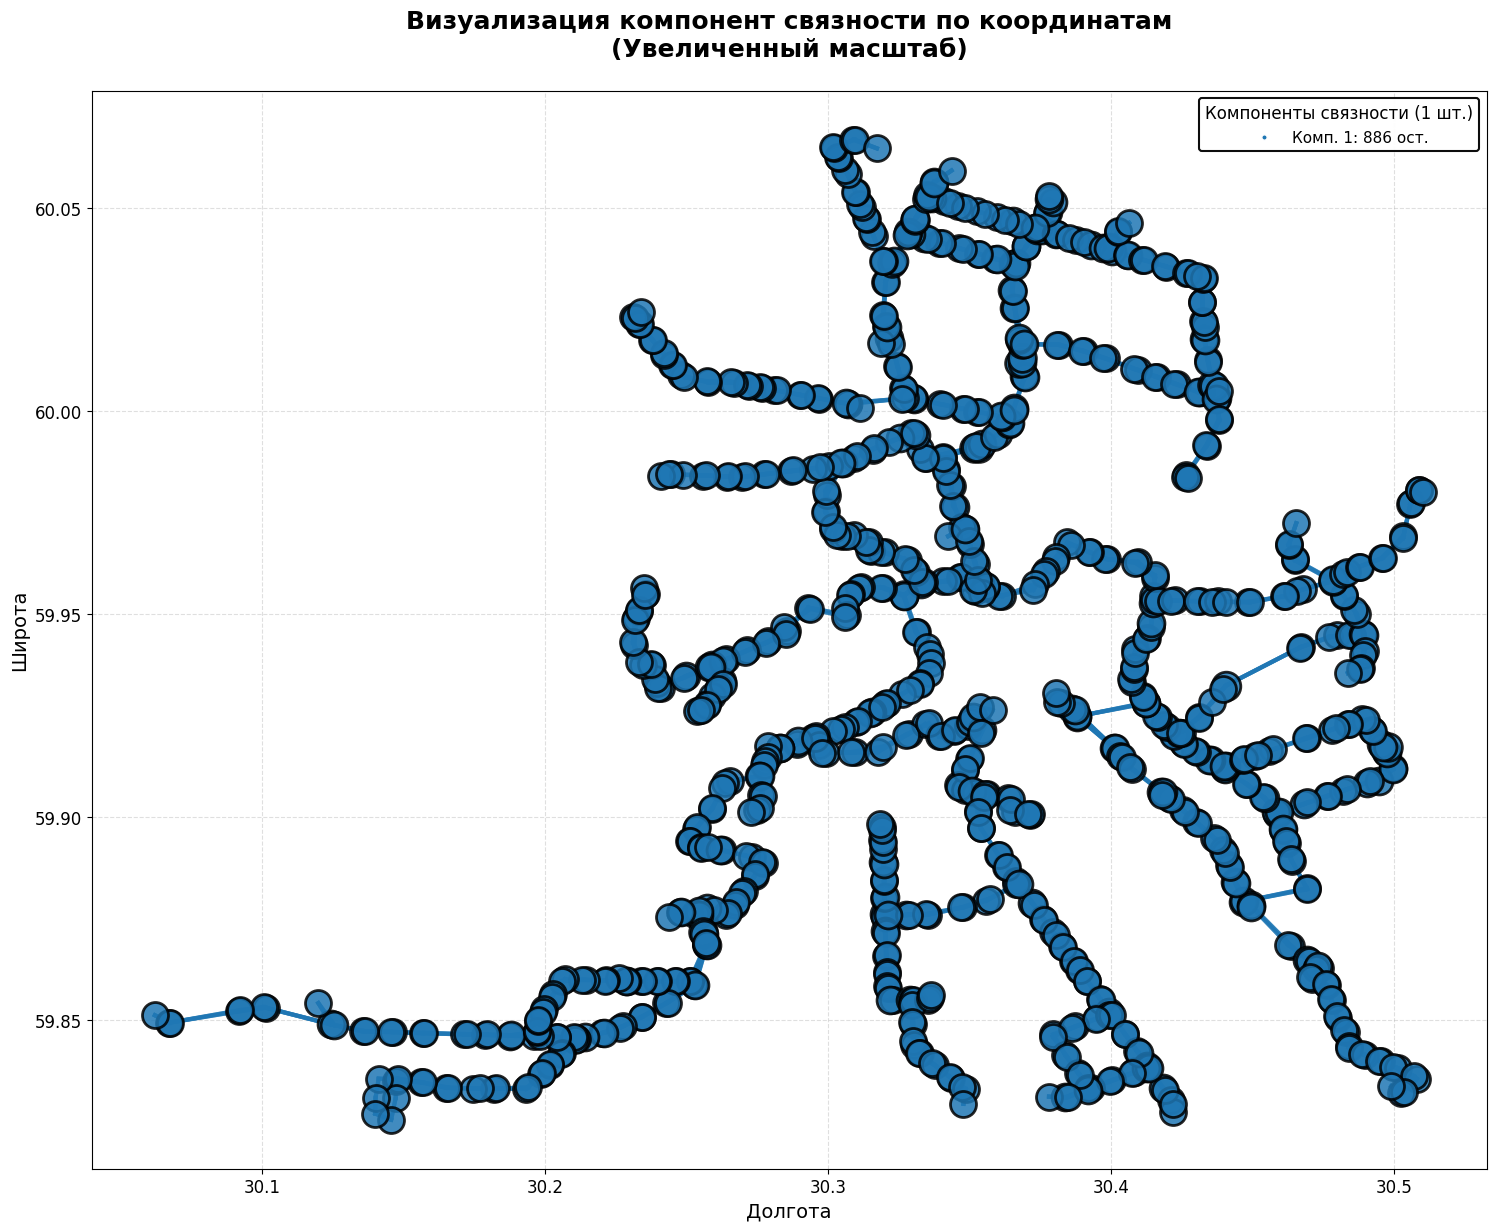

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from collections import defaultdict, deque

def parse_coordinates(coord_str):
    try:
        lat, lon = map(float, coord_str.split(','))
        return lat, lon
    except:
        return None, None

df[['lat', 'lon']] = df['Координаты остановки'].apply(
    lambda x: pd.Series(parse_coordinates(x))
)

print("Загружено данных:", len(df))
print("Уникальных остановок с координатами:", df[['lat', 'lon']].notna().all(axis=1).sum())

# 1. ПОСТРОЕНИЕ ГРАФА
print("\n1. Построение графа связности...")
graph = defaultdict(set)
coordinates = {}
stop_names = {}

# Заполняем граф и координаты
for _, row in df.iterrows():
    stop_id = row['ID остановки']
    next_stop = row['ID следующей остановки']
    stop_name = row['Название остановки']

    # Сохраняем координаты
    if pd.notna(row['lat']) and pd.notna(row['lon']):
        coordinates[stop_id] = (row['lon'], row['lat'])
        stop_names[stop_id] = stop_name

    # Добавляем связь
    if pd.notna(next_stop):
        graph[stop_id].add(next_stop)
        graph[next_stop].add(stop_id)  # неориентированный граф

    # Убедимся, что все остановки в графе
    if stop_id not in graph:
        graph[stop_id] = set()

# 2. ПОИСК КОМПОНЕНТ СВЯЗНОСТИ
def find_connected_components(graph):
    visited = set()
    components = []

    for node in graph:
        if node not in visited:
            component = []
            queue = deque([node])

            while queue:
                current = queue.popleft()
                if current not in visited:
                    visited.add(current)
                    component.append(current)

                    for neighbor in graph.get(current, []):
                        if neighbor not in visited:
                            queue.append(neighbor)

            components.append(component)

    components.sort(key=len, reverse=True)
    return components

components = find_connected_components(graph)
print(f"Найдено компонент связности: {len(components)}")

# 3. ВИЗУАЛИЗАЦИЯ НА КАРТЕ (ОДИН ГРАФИК) С УВЕЛИЧЕННЫМ МАСШТАБОМ
print("\n2. Визуализация компонент на карте с увеличенным масштабом...")

# Создаем ОДНО окно с увеличенным графиком
fig, ax = plt.subplots(1, 1, figsize=(18, 14))  # УВЕЛИЧЕННЫЙ РАЗМЕР

# Цветовая схема для компонент
colors = cm.tab20(np.linspace(0, 1, len(components)))

# Заголовок
ax.set_title('Визуализация компонент связности по координатам\n(Увеличенный масштаб)',
             fontsize=18, fontweight='bold', pad=25)

# Находим границы для масштабирования
all_lons = [coord[0] for coord in coordinates.values() if coord is not None]
all_lats = [coord[1] for coord in coordinates.values() if coord is not None]

if all_lons and all_lats:
    lon_min, lon_max = min(all_lons), max(all_lons)
    lat_min, lat_max = min(all_lats), max(all_lats)

    # РАСШИРЯЕМ МАСШТАБ: уменьшаем отступы для увеличения
    lon_padding = (lon_max - lon_min) * 0.05  # Уменьшили с 0.1 до 0.05 (увеличение масштаба)
    lat_padding = (lat_max - lat_min) * 0.05  # Уменьшили с 0.1 до 0.05

    # Альтернативно: фиксированный масштаб для большей детализации
    # Увеличиваем масштаб в 2 раза
    lon_range = lon_max - lon_min
    lat_range = lat_max - lat_min

    # Если диапазон слишком маленький, увеличиваем его для наглядности
    if lon_range < 0.001:
        lon_center = (lon_max + lon_min) / 2
        lon_min = lon_center - 0.002
        lon_max = lon_center + 0.002

    if lat_range < 0.001:
        lat_center = (lat_max + lat_min) / 2
        lat_min = lat_center - 0.002
        lat_max = lat_center + 0.002

    ax.set_xlim(lon_min - lon_padding, lon_max + lon_padding)
    ax.set_ylim(lat_min - lat_padding, lat_max + lat_padding)

    print(f"\nМасштаб карты:")
    print(f"  Долгота: от {lon_min:.6f} до {lon_max:.6f} (диапазон: {lon_range:.6f})")
    print(f"  Широта: от {lat_min:.6f} до {lat_max:.6f} (диапазон: {lat_range:.6f})")

# Собираем легенду
legend_handles = []

# НАСТРАИВАЕМ РАЗМЕРЫ ТОЧЕК ДЛЯ РАЗНЫХ КОМПОНЕНТ
# Большие компоненты получают БОЛЬШИЕ точки, маленькие - МЕНЬШИЕ
base_sizes = []
for i, component in enumerate(components):
    # Размер основы зависит от размера компоненты
    if len(component) > 50:
        base_size = 300  # Очень большая компонента
    elif len(component) > 20:
        base_size = 200  # Большая компонента
    elif len(component) > 5:
        base_size = 150  # Средняя компонента
    elif len(component) > 1:
        base_size = 120  # Маленькая компонента
    else:
        base_size = 100  # Изолированная остановка
    base_sizes.append(base_size)

print(f"\nНастройки размеров точек по компонентам:")
for i, (component, base_size) in enumerate(zip(components, base_sizes), 1):
    print(f"  Компонента {i}: {len(component)} ост., базовый размер: {base_size}")

# Рисуем каждую компоненту с разными размерами
for i, component in enumerate(components):
    color = colors[i % len(colors)]
    base_size = base_sizes[i]

    # Создаем объект для легенды с размером, соответствующим компоненте
    legend_patch = plt.Line2D([0], [0],
                             marker='o',
                             color='w',
                             markerfacecolor=color,
                             markersize=np.sqrt(base_size/20),  # Масштабируем для легенды
                             label=f'Комп. {i+1}: {len(component)} ост.')
    legend_handles.append(legend_patch)

    # Рисуем остановки с разными размерами
    for stop_id in component:
        if stop_id in coordinates and coordinates[stop_id] is not None:
            lon, lat = coordinates[stop_id]

            # РАЗНЫЙ РАЗМЕР ДЛЯ РАЗНЫХ КОМПОНЕНТ:
            # Базовый размер + зависимость от степени связности
            node_size = base_size + len(graph[stop_id]) * 25

            ax.scatter(lon, lat,
                      s=node_size,
                      color=color,
                      alpha=0.85,  # Увеличили прозрачность
                      edgecolor='black',
                      linewidth=2,  # Увеличили толщину обводки
                      zorder=10 + i)  # zorder для порядка отрисовки

            # # Добавляем подписи для ВСЕХ остановок (так как масштаб увеличен)
            # if len(component) <= 10 or len(graph[stop_id]) > 1:  # Для маленьких компонент или узлов
            #     label_offset = 0.00005 * base_size / 100  # Смещение пропорционально размеру
            #     ax.annotate(str(stop_id),
            #                xy=(lon, lat),
            #                xytext=(5, 5),
            #                textcoords='offset points',
            #                fontsize=8 if base_size < 150 else 9,
            #                fontweight='bold' if len(graph[stop_id]) > 2 else 'normal',
            #                alpha=0.8,
            #                zorder=20)

    # Рисуем связи (рёбра) с разной толщиной
    for stop_id in component:
        if stop_id in coordinates and coordinates[stop_id] is not None:
            start_lon, start_lat = coordinates[stop_id]

            for neighbor in graph[stop_id]:
                if neighbor in coordinates and coordinates[neighbor] is not None:
                    end_lon, end_lat = coordinates[neighbor]

                    # Толщина линии зависит от размера компоненты
                    line_width = 1.5 + (base_size / 100) * 0.5

                    ax.plot([start_lon, end_lon], [start_lat, end_lat],
                           color=color,
                           alpha=0.7,
                           linewidth=line_width,
                           zorder=5)

# Настройки осей с увеличенными шрифтами
ax.set_xlabel('Долгота', fontsize=14)
ax.set_ylabel('Широта', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)

# Легенда с улучшенным отображением
legend = ax.legend(handles=legend_handles,
                  loc='upper right',
                  fontsize=11,
                  title=f'Компоненты связности ({len(components)} шт.)',
                  title_fontsize=12,
                  framealpha=0.95,
                  edgecolor='black')
legend.get_frame().set_linewidth(1.5)

print("\n" + "=" * 50)
print(f"Проанализировано {len(df)} записей")
print(f"Найдено {len(components)} компонент связности")
print("=" * 50)